<table border=0px>
<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Magrib.png">
</td>
</tr>
</table>

# Analyse des sources de l'édition maghrébine du *Huff Post* (2013-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 999
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Maghreb"
huff = huff[huff.pays == edition]
huff.shape

(28653, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

Al Huffington Post     28615
The Huffington Post    24   
Le Huffington Post     12   
El Huffington Post     1    
허핑턴포스트                 1    
Name: meta, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

Al Huffington Post     28615
The Huffington Post    24   
Le Huffington Post     12   
El Huffington Post     1    
허핑턴포스트                 1    
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(28653, 13)

In [7]:
len(huff) - len(huff[metaHP])

0

Le calcul ci-haut nous indique que la balise `meta` de **tous** les articles du *Maghreb&nbsp;Post* prétendent qu'ils ont été rédigés par l'équipe maison.
<hr>
Examinons-les quand même de plus près en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

? Rédaction du HuffPost Maroc                                                                            2208
? AFP                                                                                                    1833
? Rédaction du HuffPost Algérie                                                                          1678
? HuffPost Algérie                                                                                       902 
? Le HuffPost                                                                                            897 
? HuffPost Maroc avec MAP                                                                                713 
? HuffPost Maroc                                                                                         709 
| ParYoussef Roudaby HuffPost Maroc                                                                      562 
? Rédaction du HuffPost Tunisie                                                                          493 
| ParYassi

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent à peine **0,4%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(116, 0.40484416989494987)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(25200, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(? Rédaction du HuffPost Maroc                                                                            2208
 ? Rédaction du HuffPost Algérie                                                                          1678
 ? HuffPost Algérie                                                                                       902 
 ? Le HuffPost                                                                                            897 
 ? HuffPost Maroc avec MAP                                                                                713 
 ? HuffPost Maroc                                                                                         709 
 | ParYoussef Roudaby HuffPost Maroc                                                                      562 
 ? Rédaction du HuffPost Tunisie                                                                          493 
 | ParYassine Bellamine HuffPost Tunisie                                                                  413 
 

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **25&nbsp;200 articles** signés par **1&nbsp;663 signataires différents**.<br>
Cela représente une grande majorité de l'ensemble des articles publiés par cette édition du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(25200, 87.948905873730496)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(3453, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count() 

(? AFP                                                                               1833
 ? TAP                                                                               237 
 ? APS                                                                               88  
 | Par Agence France-Presse AFPQC                                                    73  
 ? ?                                                                                 72  
 | Par Agence France Presse AFPQC                                                    56  
 ? AFPQC                                                                             50  
 ?                                                                                   44  
 | Par Abed Charef Maghreb Emergent                                                  42  
 ? MAROC INVEST                                                                      41  
 ? Maghreb Emergent                                                                  36  
 ? RCQC   

On constate qu'il s'agit ici essentiellement d'agences ou de médias de l'extérieur, comme *Maghreb Émergent* ou l'AFP, par exemples. L'ensemble de ces signatures sera donc considéré comme externe au *HuffPost Maghreb*.

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, et additionner les articles qu'on a identifiés plus haut dont la balise `meta` ne pouvait pas être associée au *HuffPost*.

In [15]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP]))
HP_non, (HP_non/len(huff))*100

(3337, 11.64624995637455)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

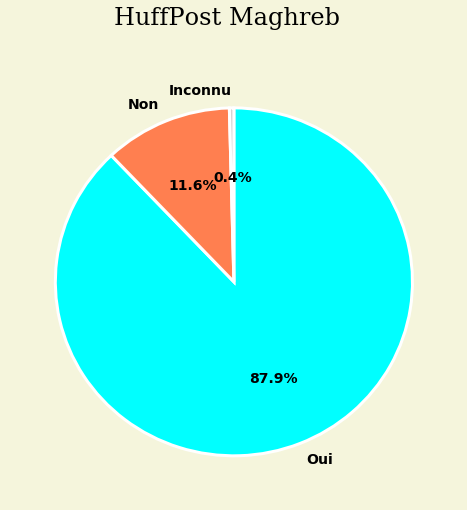

In [16]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Maghreb", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [17]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

tunisie                                                      4530
societe maroc                                                3507
international maroc                                          3007
cultures                                                     2656
Cultures algerie                                             2606
maroc                                                        2483
politique                                                    2479
international                                                2399
international algerie                                        2362
culture maroc                                                1896
politique algerie                                            1804
economie algerie                                             1693
politique maroc                                              1618
economie maroc                                               1527
societe algerie                                              1329
société tu